In [3]:
import neuro_morpho_toolbox as nmt

import os
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn import metrics
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import SimpleITK as sitk

sns.set(rc = mpl.rc_params())
%matplotlib inline


In [5]:
mpl.rc_params()

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [6]:
red = np.array([255,0,0])
green = np.array([0,255,0])
blue = np.array([0,0,255])
orange = np.array([255,105,0])
purple = np.array([160,32,240])
brown = np.array([160,82,45])

## Get SNr cell list

In [7]:
path = "/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/"
group = "SNr"
distal_thres = 0.8
midline = nmt.annotation.micron_size['z']/2
z_max = nmt.annotation.micron_size['z']
x_max = nmt.annotation.micron_size['x']
y_max = nmt.annotation.micron_size['y']



In [8]:
[ns] = pickle.load(open("neuron_set_1741cells.pickle", 'rb'))

metadata = ns.metadata.copy()
metadata = metadata[metadata['Subclass_or_type'].isin(['CP_SNr', 'CP_GPe'])]
metadata.rename(columns={'Transgenic_line':'creline',
                         'Brain_id':'brain',     
                         'Subclass_or_type':'cluster'
                        }, inplace=True)
metadata['creline'] = [i.split('-')[0] for i in metadata['creline'].tolist()]
metadata['cluster'] = [i.split('_')[1] for i in metadata['cluster'].tolist()]
metadata = metadata[['brain', 'creline', 'cluster']]
metadata = metadata[metadata['creline'].isin(['Tnnt1', 'Vipr2', 'Plxnd1', 'Pvalb'])]
metadata = metadata[metadata['cluster']=='SNr']
nlist = metadata.index.tolist()

metadata.head()


,brain,creline,cluster
17302_00001,17302,Tnnt1,SNr
17302_00002,17302,Tnnt1,SNr
17302_00003,17302,Tnnt1,SNr
17302_00005,17302,Tnnt1,SNr
17302_00006,17302,Tnnt1,SNr


In [9]:
def total_length(swc):
    cswc = swc.copy()
    clist = cswc[cswc['parent'].isin(cswc.index)].index.tolist()
    plist = cswc.loc[clist, 'parent'].tolist()
    res = np.sum(np.square(np.array(cswc.loc[clist, ['x', 'y', 'z']]) - 
                           np.array(cswc.loc[plist, ['x', 'y', 'z']])), axis=1)
    res = np.sum(np.sqrt(res))
    return res

## Soma

In [10]:
soma_df = ns.features['soma_features'].raw_data.copy()
soma_df = soma_df.loc[nlist, ['x', 'y', 'z']]
soma_df.head()

,x,y,z
17302_00001,4912.750,4900.875,2445.775
17302_00002,4815.650,4976.625,2421.275
17302_00003,4908.250,4910.875,2340.625
17302_00005,4828.825,4615.100,2588.875
17302_00006,5114.050,4599.975,2407.525


## Axon

In [11]:
'''
save axon arbors as dataframes,
only consider those within target area
'''

tid = nmt.bs.get_all_child_id(nmt.bs.name_to_id(group))

In [12]:
def get_node_regions(swc, scale=1/25):
    cswc = swc.copy()
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']] * scale
    cswc[['x', 'y', 'z']] = cswc[['x', 'y', 'z']].round(0).astype(int)
    cswc['region'] = 0
    idlist = cswc[((cswc.x>0) & (cswc.x<nmt.annotation.array.shape[0]) &
                   (cswc.y>0) & (cswc.y<nmt.annotation.array.shape[1]) &
                   (cswc.z>0) & (cswc.z<nmt.annotation.array.shape[2])
                  )].index.tolist()
    cswc.loc[idlist, 'region'] = nmt.annotation.array[cswc.x, cswc.y, cswc.z]
    cswc['region'] = cswc['region'].astype(int)
    return cswc

def get_center(swc, silent=True):
    df = swc.copy()[['x', 'y', 'z']]
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    # exclude outliers
    md = metrics.euclidean_distances(np.array(df.loc[cid]).reshape(1, 3), df).reshape(-1,)
    tp = df[md>1000] # define outliers
    outlier_ratio = len(tp) / len(df) * 100
    if not silent:            
        if outlier_ratio>10:
            print("%.2f%% arbor excluded." % (outlier_ratio))
    df.drop(index=tp.index, inplace=True)
    # Re-center
    distance = metrics.euclidean_distances(df)
    cid = np.argmin(np.mean(distance, axis=1))
    cid = df.index.tolist()[cid]
    return cid, outlier_ratio
 

ca = ns.neurons[nlist[0]].swc.copy()
ca['region'] = get_node_regions(ca)['region']
ca = ca[ca.region.isin(tid)]
cc, outlier_ratio = get_center(ca, False)
cc = ca.loc[cc]
cc

type         2.000
x         8649.000
y         5124.175
z         4174.750
r            1.000
parent    5251.000
region     381.000
Name: 5252, dtype: float64

In [13]:
axon_dict = {}
nlist_selected = []
axon_df = pd.DataFrame(index=nlist, columns=['x', 'y', 'z', 'length'])
for i in nlist:
    cswc = ns.neurons[i].swc.copy()
    cswc = cswc[cswc.type==2]
    cswc['region'] = get_node_regions(cswc)['region']
    cswc = cswc[cswc.region.isin(tid)]
    cswc = cswc[cswc.parent.isin(cswc.index)]
    if len(cswc)>0:
        cc, outlier_ratio = get_center(cswc, True)
        cc = cswc.loc[cc]
    cl = total_length(cswc)/1000
    if cl < 1:
        print('%s:\t%.2fmm' % (i, cl))
    else:
        nlist_selected.append(i)
    axon_dict.update({i:cswc})
    axon_df.loc[i, ['x', 'y', 'z', 'length']] = cc[['x', 'y', 'z']].tolist()+[cl]


17787_00026:	0.20mm
18454_00093:	0.90mm
18457_00008:	0.88mm
18457_00014:	0.04mm
18457_00034:	0.70mm
18457_00082:	0.62mm
18457_00103:	0.00mm
18464_00108:	0.27mm
18465_00033:	0.14mm


## distance soma v.s. axon

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



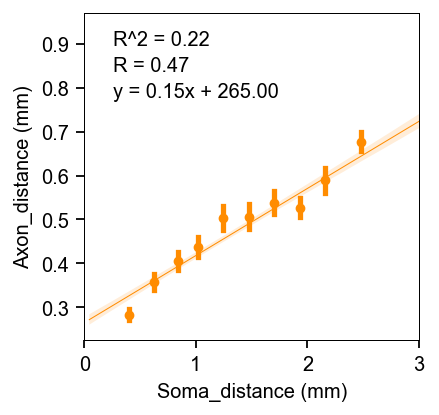

In [51]:
iu = np.triu_indices(len(nlist_selected), k=1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)
axon_dist = sklearn.metrics.pairwise_distances(axon_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_distance (mm)':axon_dist[:,0],
                  })/1000

lm = sklearn.linear_model.LinearRegression()
lm.fit(soma_dist, axon_dist)
r2 = lm.score(soma_dist, axon_dist)
c1 = lm.coef_
c2 = lm.intercept_
r = np.corrcoef(soma_dist[:,0], axon_dist[:,0])[0,1]

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_distance (mm)",
                data=df, 
                x_bins=10,
                order=1, 
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15},
                x_jitter=.1)
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05
ax.set_xlim((0,3))
ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.79, "y = %.2fx + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top'})

fig.savefig("../Figure/soma_axon_regression_SNr_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_distance_SNr_v2.pickle", 'wb'))

## Axon overlaps

Merging child region SNr into region SNr
Loading time for region SNr : 0.59


(7250.0, 9550.0) (3875.0, 6325.0) (2925.0, 5450.0)
x steps:	30
y steps:	32
z steps:	33
17302_00001 17302_00002
0.5750947483798737


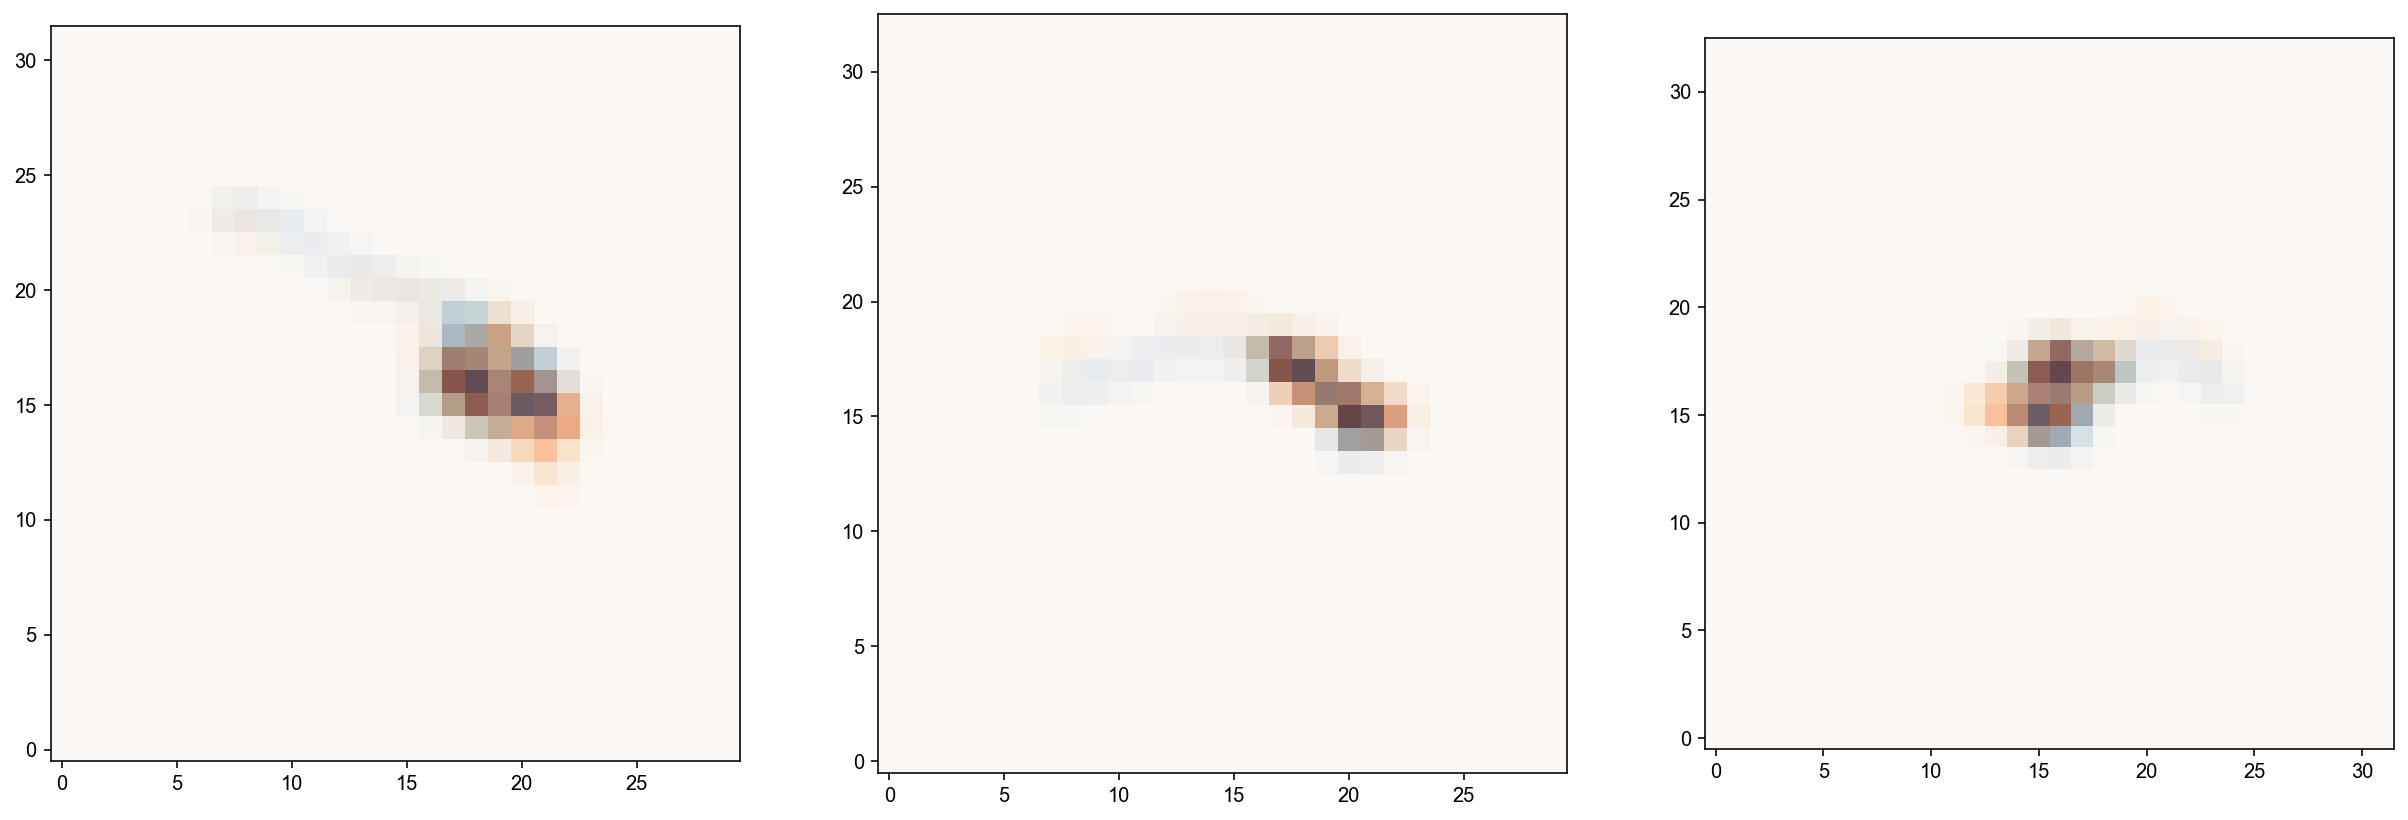

In [15]:
# Get subvolumn
region_id = nmt.bs.name_to_id(group)
tp = nmt.mergeROI([region_id], nmt.annotation.array)
tp[:,:,int(midline/25):] = 0
tp = np.where(tp==region_id)
xlim = (np.max([np.min(tp[0])*25.0 - 500, 0]), 
        np.min([np.max(tp[0])*25.0 + 500, x_max]))
ylim = (np.max([np.min(tp[1])*25.0 - 500, 0]), 
        np.min([np.max(tp[1])*25.0 + 500, y_max]))
zlim = (np.max([np.min(tp[2])*25.0 - 500, 0]), 
        np.min([np.max(tp[2])*25.0 + 500, z_max]))


print(xlim, ylim, zlim)

step_size = 75
x_steps = int((xlim[1]-xlim[0])/step_size)
y_steps = int((ylim[1]-ylim[0])/step_size)
z_steps = int((zlim[1]-zlim[0])/step_size)
print("x steps:\t%d\ny steps:\t%d\nz steps:\t%d" % (x_steps, y_steps, z_steps))

def density_estimation(cur_name, x_steps=20, y_steps=20, plot=True):
    z = axon_dict[cur_name].swc.copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y']])

    p = np.zeros((x_steps, y_steps))
    xs = np.linspace(xlim[0], xlim[1], num=x_steps)
    ys = np.linspace(ylim[0], ylim[1], num=y_steps)
    for i in range(x_steps):
        for j in range(y_steps):
            p[i,j] = np.exp(kde.score(np.array([xs[i], ys[j]]).reshape(1,2)))
    p = p
    p = p / np.sum(p)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(p)
    return p

def density_estimation_3d(cur_name, x_steps=20, y_steps=20, z_steps=20, plot=True):
    z = axon_dict[cur_name].copy()

    kde = sklearn.neighbors.KernelDensity(bandwidth=50)
    kde.fit(z[['x', 'y', 'z']])

    p = np.zeros((x_steps, y_steps, z_steps))
    tp = np.where(p==0)
    tp = np.hstack([tp[0].reshape(-1,1), 
                    tp[1].reshape(-1,1),
                    tp[2].reshape(-1,1)
                   ])*step_size+np.array([xlim[0], ylim[0], zlim[0]]).reshape(1,-1)
    p = np.exp(kde.score_samples(tp)).reshape(x_steps, y_steps, z_steps, order="C")
    p = p / np.sum(p)
    
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(7,7))
        ax.imshow(np.transpose(np.max(p, axis=2)), origin='lower', cmap='Reds', alpha=0.75, aspect='equal')
    return p

def get_overlap(p1, p2):
    res = np.zeros(p1.shape)
    # Calculate the frequency under curve
    lab = np.where(p1>=p2)
    res[lab] = p2[lab]
    lab = np.where(p1<p2)
    res[lab] = p1[lab]
    return np.sum(res)


# 3D version
neuron_1 = nlist[0]
neuron_2 = nlist[1]
p1 = density_estimation_3d(neuron_1, x_steps, y_steps, z_steps, False)
p2 = density_estimation_3d(neuron_2, x_steps, y_steps, z_steps, False)

print(neuron_1, neuron_2)
print(get_overlap(p1, p2))

fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].imshow(np.transpose(np.max(p1, axis=2)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[0].imshow(np.transpose(np.max(p2, axis=2)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[1].imshow(np.transpose(np.max(p1, axis=1)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[1].imshow(np.transpose(np.max(p2, axis=1)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')

ax[2].imshow(np.transpose(np.max(p1, axis=0)), origin='lower', cmap='Blues', alpha=0.75, aspect='equal')
ax[2].imshow(np.transpose(np.max(p2, axis=0)), origin='lower', cmap='Oranges', alpha=0.5, aspect='equal')


## Axon overlaps v.s. Soma distance

In [16]:
p_dict = {}
for cur_name in nlist_selected[:]:
    p_dict[cur_name] = density_estimation_3d(cur_name, x_steps, y_steps, z_steps, False)

overlap_df = pd.DataFrame(index=nlist_selected, columns=nlist_selected)
for i in nlist_selected[:]:
    for j in nlist_selected[:]:
        overlap_df.loc[i,j] = get_overlap(p_dict[i], p_dict[j])

In [18]:
overlap_df

,17302_00001,17302_00002,17302_00003,17302_00005,17302_00006,17302_00007,17302_00009,17302_00010,17302_00011,17302_00027,...,18465_00005,18465_00034,18465_00035,18465_00036,18465_00040,18465_00157,18465_00168,18465_00219,18867_4724_x12558_y16835,18867_4826_x11914_y16564
17302_00001,1,0.575095,0.319574,0.00713744,0.00745517,0.527076,0.306751,0.172451,0.266772,0.246846,...,0.231151,0.184971,0.076875,0.176352,0.0566204,0.257665,0.322794,0.0129699,0.191957,0.0778145
17302_00002,0.575095,1,0.177732,0.00686398,0.00719713,0.433621,0.154088,0.134233,0.311717,0.120495,...,0.206088,0.231493,0.0676438,0.155056,0.0423525,0.285606,0.317472,0.00316577,0.135332,0.0684136
17302_00003,0.319574,0.177732,1,0.000431868,0.000477647,0.509966,0.844339,0.465954,0.426037,0.57997,...,0.238401,0.094505,0.0977925,0.104411,0.0972703,0.0375933,0.0490733,0.0193212,0.228606,0.181651
17302_00005,0.00713744,0.00686398,0.000431868,1,0.239305,0.00939962,0.000444176,0.000406551,0.00614945,0.000191088,...,0.000136963,5.03369e-06,9.50789e-10,1.93616e-05,0.00614754,0.122392,0.0543562,0.245428,0.000798314,0.00548927
17302_00006,0.00745517,0.00719713,0.000477647,0.239305,1,0.0078823,0.000523689,0.000340486,0.0070294,0.000195685,...,0.00141927,2.91184e-05,1.97113e-07,6.78975e-05,0.00713184,0.239418,0.176996,0.117405,0.00321322,0.00316854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18465_00157,0.257665,0.285606,0.0375933,0.122392,0.239418,0.246534,0.0434777,0.0105128,0.081554,0.0153849,...,0.15072,0.0651031,0.00464378,0.0809619,0.00696465,1,0.340532,0.0569012,0.081098,0.0125452
18465_00168,0.322794,0.317472,0.0490733,0.0543562,0.176996,0.211726,0.0511987,0.0197761,0.062205,0.0215898,...,0.1676,0.25943,0.0134148,0.186757,0.0142146,0.340532,1,0.0218421,0.0527676,0.0259989
18465_00219,0.0129699,0.00316577,0.0193212,0.245428,0.117405,0.0210943,0.0201336,0.00366567,0.00337243,0.0131397,...,0.0673625,0.00316647,0.000678306,0.0319284,0.0890206,0.0569012,0.0218421,1,0.0859819,0.0178741
18867_4724_x12558_y16835,0.191957,0.135332,0.228606,0.000798314,0.00321322,0.199026,0.223762,0.183182,0.259666,0.132343,...,0.190212,0.0167354,0.000272784,0.0138162,0.0222944,0.081098,0.0527676,0.0859819,1,0.34454


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



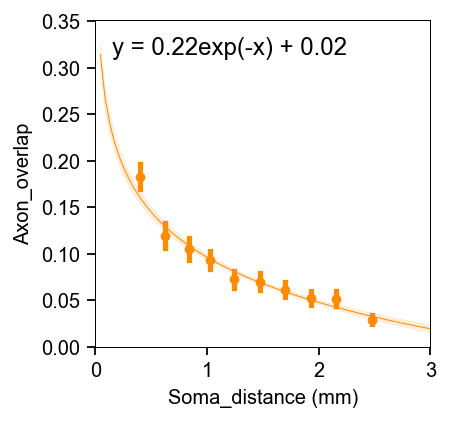

In [40]:
iu = np.triu_indices(len(nlist_selected[:]), 1)
soma_dist = sklearn.metrics.pairwise_distances(soma_df.loc[nlist_selected, ['x', 'y', 'z']])[iu].reshape(-1,1)/1000
axon_over = np.array(overlap_df)[iu].reshape(-1,1)


df = pd.DataFrame({'Soma_distance (mm)':soma_dist[:,0], 
                   'Axon_overlap':axon_over[:,0],
                   'Neuron_1':[nlist_selected[i] for i in iu[0]],
                   'Neuron_2':[nlist_selected[i] for i in iu[1]],
                  }
                 )
df = df.astype({'Soma_distance (mm)':float, 
                   'Axon_overlap':float,
                   'Neuron_1':str,
                   'Neuron_2':str,
                  }
              )


fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.tick_params(length=4, width=1, color='k')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

g = sns.regplot("Soma_distance (mm)", "Axon_overlap",
                data=df, 
                x_bins=10,
                order=1, 
                logx=True,
                truncate=True,
                ax=ax,
                color='darkorange',
                line_kws={'lw':0.5},
                scatter_kws={'s':15})
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlim((0,3))
xlim = ax.get_xlim()
xr = (xlim[1]-xlim[0])
ylim = ax.get_ylim()
yr = (ylim[1]-ylim[0])
txlim = xlim[0] + xr*0.05

lm = sklearn.linear_model.LinearRegression()
ind = df[((df['Soma_distance (mm)']>xlim[0]) & (df['Soma_distance (mm)']<xlim[1]))].index.tolist()
lm.fit(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
       df.loc[ind, ['Axon_overlap']])
c1 = lm.coef_
c2 = lm.intercept_
# r2 = lm.score(np.exp(-df.loc[ind, ['Soma_distance (mm)']]), 
#               df.loc[ind, ['Axon_overlap']])  # coefficient of determination
# ax.text(txlim, ylim[0] + yr*0.95, "R^2 = %.2f" % (r2), fontdict={'ha':'left', 'va':'top'})
# ax.text(txlim, ylim[0] + yr*0.87, "R = %.2f" % (r), fontdict={'ha':'left', 'va':'top'})
ax.text(txlim, ylim[0] + yr*0.95, "y = %.2fexp(-x) + %.2f" % (c1, c2), fontdict={'ha':'left', 'va':'top', 'fontsize':12})


fig.savefig("../Figure/soma_axonoverlap_regression_"+group+"_v2.pdf", bbox_inches='tight')

pickle.dump([df], open("Soma_axon_overlap_SNr_v2.pickle", 'wb'))

In [54]:
0.22*np.exp(-0.1)

0.1990642319679111

In [21]:
df_sum_overlap = pd.DataFrame(index=nlist_selected, columns=['Total_overlap'])
for cur_name in nlist_selected:
    df_sum_overlap.loc[cur_name, 'Total_overlap'] = np.sum(df.loc[df.Neuron_1 == cur_name, "Axon_overlap"]) + np.sum(df.loc[df.Neuron_2 == cur_name, "Axon_overlap"])

In [22]:
import igraph


def get_nearest_neighbors(sample_name, df, knn = 3, thres=0.1):
    df = df[df.Axon_overlap>thres]
    df = df[((df.Neuron_1==sample_name) | (df.Neuron_2==sample_name))].sort_values(['Axon_overlap'], ascending=False)
    res = [sample_name]
    for i in range(np.min([knn-1, len(df)])):
        cur_index = df.index[i]
        if df.loc[cur_index, 'Neuron_1'] != sample_name:
            res.append(df.loc[cur_index, 'Neuron_1'])
        else:
            res.append(df.loc[cur_index, 'Neuron_2'])
    return res

def match1d(query, target):
    if not type(query)==list:
        query = query.tolist()
    if not type(target)==list:
        target = target.tolist()
    target = dict(zip(target, range(len(target))))
    if (set(query).issubset(set(target.keys()))):
        result = [target[i] for i in query]
        return (np.array(result))
    else:
        print("Query should be a subset of target!")
        return
    
def get_snn_strength(s1, s2, df, knn = 3, thres=0.1):
    knn1 = get_nearest_neighbors(s1, df, knn, thres)
    knn2 = get_nearest_neighbors(s2, df, knn, thres)
#     print(s1, knn1)
#     print(s2, knn2)
    shared = set(knn1).intersection(set(knn2))
    shared = np.array(list(shared))
    if (len(shared) > 0):  # When i and j have shared knn
        strength = knn - (match1d(shared, knn1) + match1d(shared, knn2) + 2) / 2
        strength = max(strength)
    else:
        strength = 0
    return strength

def SNN(name_list, df, knn=3, thres=0.1):
    res = pd.DataFrame(columns=['Neuron_1', 'Neuron_2', 'strength'])
    ct = 0
    for i in range(len(name_list)-1):
        for j in range(i+1, len(name_list)):
            s1 = name_list[i]
            s2 = name_list[j]
            strength = get_snn_strength(s1, s2, df, knn, thres)
            res.loc[ct] = [s1, s2, strength]
            ct = ct+1
    return res



def get_clusters_community(df, thres=0):
    df = df[df.strength>thres]
    g = igraph.Graph()
    # in order to add edges, we have to add all the vertices first
    # iterate through edges and put all the vertices in a list
    vertex = []
    edge_list = [(df.Neuron_1[i], df.Neuron_2[i]) for i in df.index.tolist()]
    for e in edge_list:
        vertex.extend(e)
    g.add_vertices(list(set(vertex)))  # add a list of unique vertices to the graph
    g.add_edges(edge_list)  # add the edges to the graph.
    g.es['weights'] = df.strength.tolist()
    '''
    Clustering
    '''
#     res = (g.community_fastgreedy(weights='weights').as_clustering().membership)
    res = (g.community_multilevel(weights='weights', return_levels=False).membership) # Louvain
    res = pd.DataFrame(res, index=g.vs['name'], columns=['cluster'])
    return res


In [29]:
axon_df.loc[axon_cluster.index]

,x,y,z,length,BrainID,CreLine,Overlap,clusters
18457_00113,8780.750,5096.800,3745.825,6.52706,S_18457,Vipr2,4.97666,c0
17545_00045,8655.475,4943.875,3823.825,2.98912,S_17545,Tnnt1,9.84584,c1
17302_00094,8604.750,5048.525,3910.050,3.79897,S_17302,Tnnt1,10.7957,c0
17545_00008,8539.125,4826.075,3880.300,6.59477,S_17545,Tnnt1,7.4737,c1
17787_00050,8517.875,4828.700,3725.550,12.7756,S_17787,Plxnd1,7.41801,c1
...,...,...,...,...,...,...,...,...
17787_00014,8067.600,5646.800,4235.350,5.594,S_17787,Plxnd1,3.81359,c4
18454_00021,8156.125,5704.725,4105.325,2.25654,S_18454,Tnnt1,2.74569,c4
17302_00010,8599.275,5354.850,4225.675,4.16012,S_17302,Tnnt1,7.67009,c3
18465_00219,8308.200,5142.975,3786.525,8.33486,S_18465,Vipr2,7.26811,c0


In [36]:
edge_thres = 0.1
knn = 8
df_snn = SNN(nlist_selected, df, knn, edge_thres)
df_snn = df_snn[df_snn.strength>0]
axon_cluster = get_clusters_community(df_snn)

soma_df = soma_df.loc[nlist_selected]
axon_df = axon_df.loc[nlist_selected]

soma_df['BrainID'] = ["S_"+i.split("_")[0] for i in soma_df.index.tolist()]
soma_df['CreLine'] = [metadata.loc[i, "creline"] for i in soma_df.index.tolist()]
soma_df['Overlap'] = df_sum_overlap.loc[soma_df.index]

axon_df['BrainID'] = ["S_"+i.split("_")[0] for i in axon_df.index.tolist()]
axon_df['CreLine'] = [metadata.loc[i, "creline"] for i in axon_df.index.tolist()]
axon_df['Overlap'] = df_sum_overlap.loc[axon_df.index]

soma_df['clusters'] = 'Others'
soma_df.loc[axon_cluster.index, 'clusters'] = ['c'+str(i) for i in axon_cluster.cluster.tolist()]
axon_df['clusters'] = 'Others'
axon_df.loc[axon_cluster.index, 'clusters'] = ['c'+str(i) for i in axon_cluster.cluster.tolist()]

soma_df[['x', 'y', 'z']] = soma_df[['x', 'y', 'z']].astype(float)
axon_df[['x', 'y', 'z']] = axon_df[['x', 'y', 'z']].astype(float)

print(soma_df.clusters.value_counts())

c2    38
c1    36
c0    13
Name: clusters, dtype: int64


In [50]:
'''
Find representative swc files
'''
# soma_df[((soma_df.clusters=='c1') & (soma_df.registration=='CP'))].sort_values(['y'])
soma_df[((soma_df.clusters=='c0'))].sort_values(['x'])


,x,y,z,BrainID,CreLine,Overlap,clusters
17545_00132,4991.625,4267.475,2734.600,S_17545,Tnnt1,10.9777,c0
17302_00094,5002.800,4479.300,2424.150,S_17302,Tnnt1,10.7957,c0
17545_00131,5024.175,4244.475,2763.375,S_17545,Tnnt1,13.1254,c0
17787_00019,5041.750,3456.125,2570.800,S_17787,Plxnd1,8.31367,c0
17302_00097,5047.050,4389.525,2358.000,S_17302,Tnnt1,9.08558,c0
17302_00095,5049.375,4359.975,2477.925,S_17302,Tnnt1,12.3593,c0
17302_00086,5071.200,4402.100,2621.400,S_17302,Tnnt1,11.9977,c0
17302_00093,5083.850,4453.450,2463.250,S_17302,Tnnt1,10.6117,c0
18455_00182,5234.950,4147.875,2980.025,S_18455,Tnnt1,12.0462,c0
18457_00113,5373.500,5713.950,2376.050,S_18457,Vipr2,4.97666,c0


In [42]:
rep_list = ['17787_00019', '18465_00219', '18465_00039']
soma_df.loc[rep_list]

,x,y,z,BrainID,CreLine,Overlap,clusters
17545_00131,5024.175,4244.475,2763.375,S_17545,Tnnt1,13.1254,c0
18465_00003,4226.725,4012.750,2754.150,S_18465,Vipr2,8.6774,c1
18454_00018,4336.750,3210.450,3840.925,S_18454,Tnnt1,3.33253,c2


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:3

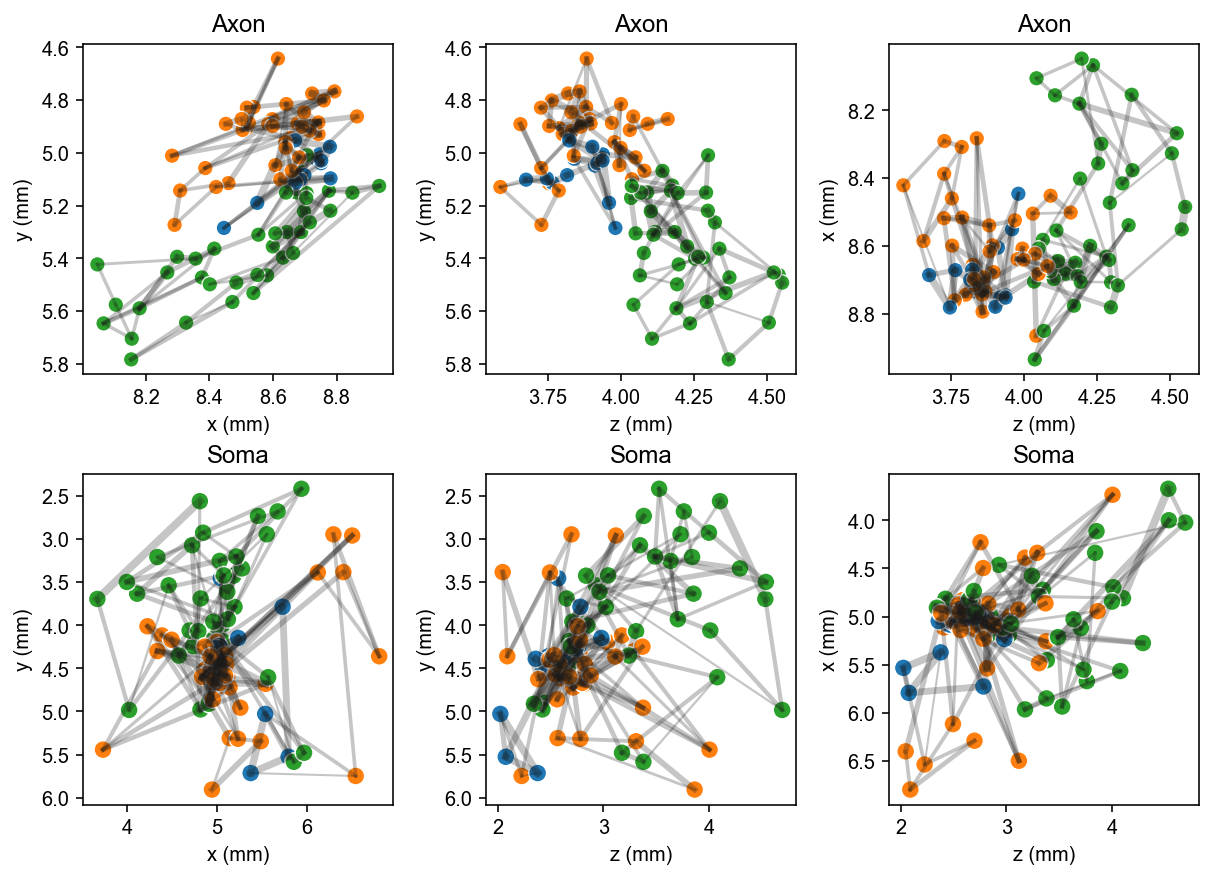

In [39]:
fig, ax = plt.subplots(2,3, figsize=(10,7), gridspec_kw={'hspace':0.3, 'wspace':0.3})
uclusters=sorted(list(set(soma_df.clusters.tolist())))
adf = axon_df.copy()
adf[['x','y','z']] = adf[['x','y','z']]/1000
sdf = soma_df.copy()
sdf[['x','y','z']] = sdf[['x','y','z']]/1000

sthres = np.percentile(df_snn.strength, 80)

axis_pairs = [['x', 'y'], ['z', 'y'], ['z', 'x']]

for i in range(3):
    cx = axis_pairs[i][0]
    cy = axis_pairs[i][1]
    # Axon map
    cax = ax[0,i]
    for cur_name in sdf.index.tolist():
        tp = df_snn[df_snn.Neuron_1==cur_name]
        tp = tp[tp['strength']>sthres]
        for j in tp.index.tolist():
            n = tp.loc[j, ["Neuron_1", "Neuron_2"]].tolist()
            cax.plot(adf.loc[n, cx], 
                     adf.loc[n, cy],
                     lw=df.loc[j, 'Axon_overlap']*7, c='k', alpha=0.25)
    sns.scatterplot(cx, cy, data=adf, 
                    hue='clusters', 
                    hue_order=uclusters,
                    s=60,
                    legend=False,
                    ax=cax)
    cax.invert_yaxis()
    cax.set_title('Axon')
    cax.set_xlabel(cx+' (mm)')
    cax.set_ylabel(cy+' (mm)')

    # Soma map
    cax = ax[1,i]
    for cur_name in sdf.index.tolist():
        tp = df_snn[df_snn.Neuron_1==cur_name]
        tp = tp[tp['strength']>sthres]
        for j in tp.index.tolist():
            n = tp.loc[j, ["Neuron_1", "Neuron_2"]].tolist()
            cax.plot(sdf.loc[n, cx], 
                     sdf.loc[n, cy], 
                     lw=df.loc[j, 'Axon_overlap']*7, c='k', alpha=0.25)
    sns.scatterplot(cx, cy, data=sdf, 
                    hue='clusters', 
                    hue_order=uclusters,
                    s=80,
                    legend=False,
                    ax=cax)
    cax.invert_yaxis()
    cax.set_title('Soma')
    cax.set_xlabel(cx+' (mm)')
    _ = cax.set_ylabel(cy+' (mm)')

fig.savefig("../Figure/axon_network_"+group+"_v2.pdf", bbox_inches='tight')

## Generating 3D topography

In [45]:
def my_get_segments(swc):
    swc = swc.copy()
    # lab = [i for i,name in enumerate(swc.index.tolist()) if swc.loc[name, "parent"]!=(-1)]
    child = swc[(swc.parent.isin(swc.index.tolist()))]
    parent = swc.loc[child.parent]
    rho, theta, phi = nmt.cart2pol_3d(np.array(child[["x", "y", "z"]]) - np.array(parent[["x", "y", "z"]]))
    res = pd.DataFrame({"type": child.type,
                        "rho": rho,
                        "theta": theta,
                        "phi": phi,
                        "x": (np.array(child.x) + np.array(parent.x)) / 2,
                        "y": (np.array(child.y) + np.array(parent.y)) / 2,
                        "z": (np.array(child.z) + np.array(parent.z)) / 2,
                        })
    res.index = range(1, len(child)+1)
    # soma
    soma = swc[((swc.type==1) & (swc.parent==-1))]
    if len(soma)>0:
        soma_res = pd.DataFrame({"type": 1,
                                 "rho": 1,
                                 "theta": 0,
                                 "phi": 0,
                                 "x": soma.x.iloc[0],
                                 "y": soma.y.iloc[0],
                                 "z": soma.z.iloc[0],
                                },
                                index=[0])
        res = soma_res.append(res)
    res.dropna()
    return res

def density_estimation_cluster_3d(cluster, group="soma", step_size = 25, plot=True, bandwidth=50):
    
    # 1. Get data matrix
    if group == "soma":
        xlim = (np.max([np.min(soma_df['x']) - 500, 0]), 
                np.min([np.max(soma_df['x']) + 500, x_max]))
        ylim = (np.max([np.min(soma_df['y']) - 500, 0]), 
                np.min([np.max(soma_df['y']) + 500, y_max]))
        zlim = (np.max([np.min(soma_df['z']) - 500, 0]), 
                np.min([np.max(soma_df['z']) + 500, midline]))
        df = soma_df[soma_df.clusters==cluster]
    elif group == "axon":
        xlim = (np.max([np.min(axon_df['x']) - 500, 0]), 
                np.min([np.max(axon_df['x']) + 500, x_max]))
        ylim = (np.max([np.min(axon_df['y']) - 500, 0]), 
                np.min([np.max(axon_df['y']) + 500, y_max]))
        zlim = (np.max([np.min(axon_df['z']) - 500, 0]), 
                np.min([np.max(axon_df['z']) + 500, midline]))
#         df = axon_df[axon_df.clusters==cluster]
        cell_list = axon_df[axon_df.clusters==cluster].index.tolist()
        df_list = [my_get_segments(axon_dict[i]).loc[:,['x', 'y', 'z', 'rho']] for i in cell_list]
        df = pd.concat(df_list, axis=0)
#         print("axon_df combined")  
        print("kde # of points:\t%d" % (len(df)))
        df = df[df.rho>0]
#         print(xlim, ylim, zlim)
    else:
        return
    
    # 2. Get density matrix
    kde = sklearn.neighbors.KernelDensity(bandwidth=bandwidth)
    if group == 'soma':
        kde.fit(df[['x', 'y', 'z']] / step_size)
    else:
        kde.fit(df[['x', 'y', 'z']] / step_size, sample_weight=df['rho'])

    x_steps = int((xlim[1] - xlim[0]) / step_size)
    y_steps = int((ylim[1] - ylim[0]) / step_size)
    z_steps = int((zlim[1] - zlim[0]) / step_size)
    
    print("size of density space: %d" % (x_steps * y_steps * z_steps))
    
    p = np.zeros((x_steps, y_steps, z_steps))    
    tp = np.where(p==0)
    tp = np.hstack([tp[0].reshape(-1,1), 
                    tp[1].reshape(-1,1),
                    tp[2].reshape(-1,1)
                   ])+np.array([xlim[0], ylim[0], zlim[0]]).reshape(1,-1)/step_size
    p = np.exp(kde.score_samples(tp)).reshape(x_steps, y_steps, z_steps, order="C")
    p = p / np.max(p)*255
    
    res = np.zeros(nmt.annotation.array.shape)
    res[int(xlim[0]/step_size):(int(xlim[0]/step_size) + x_steps),
        int(ylim[0]/step_size):(int(ylim[0]/step_size) + y_steps),
        int(zlim[0]/step_size):(int(zlim[0]/step_size) + z_steps)
       ] = p
    res = res.astype(np.int16)
    return res

def merge_density(density_list, color_list):
    assert len(density_list)==len(color_list), 'density and color list sizes do not match'
    tp = np.zeros((density_list[0].shape[0], 
                   density_list[0].shape[1], 
                   density_list[0].shape[2], 
                   3
                  ))
    for i in range(len(density_list)):
        for j in range(3):
            tp[:,:,:,j] = tp[:,:,:,j] + density_list[i] * color_list[i][j] / 255.0 / len(density_list)
    for j in range(3):
        if np.max(tp[:,:,:,j])>=255:
            print(j, color_list[i][j], np.max(tp[:,:,:,j]))
            tp[:,:,:,j] = tp[:,:,:,j] / np.max(tp[:,:,:,j]) * 255.0
    tp = tp.astype(np.int16)
    return tp


color_list = [blue, orange, green, red, purple, brown]
n_cluster = 3
density_list = []
for i in range(n_cluster):
    cur_cluster = "c"+str(i)
    t2 = density_estimation_cluster_3d(cur_cluster, "axon", step_size=25, bandwidth=1) # Take smaller bandwith 
    t1 = density_estimation_cluster_3d(cur_cluster, "soma", step_size=25, bandwidth=1)
    density_list = density_list + [(t1.astype(np.float32)+t2.astype(np.float32))]
    
tp = merge_density(density_list, color_list[:n_cluster])

img = sitk.GetImageFromArray(np.swapaxes(tp, 0,2))
sitk.WriteImage(img, group+'_soma_distribution.nrrd', True)
print("Done")

kde # of points:	6469
size of density space: 452625
size of density space: 3125424
kde # of points:	4711
size of density space: 452625
size of density space: 3125424
kde # of points:	20287
size of density space: 452625
size of density space: 3125424
Done


NameError: name 'cp_map' is not defined

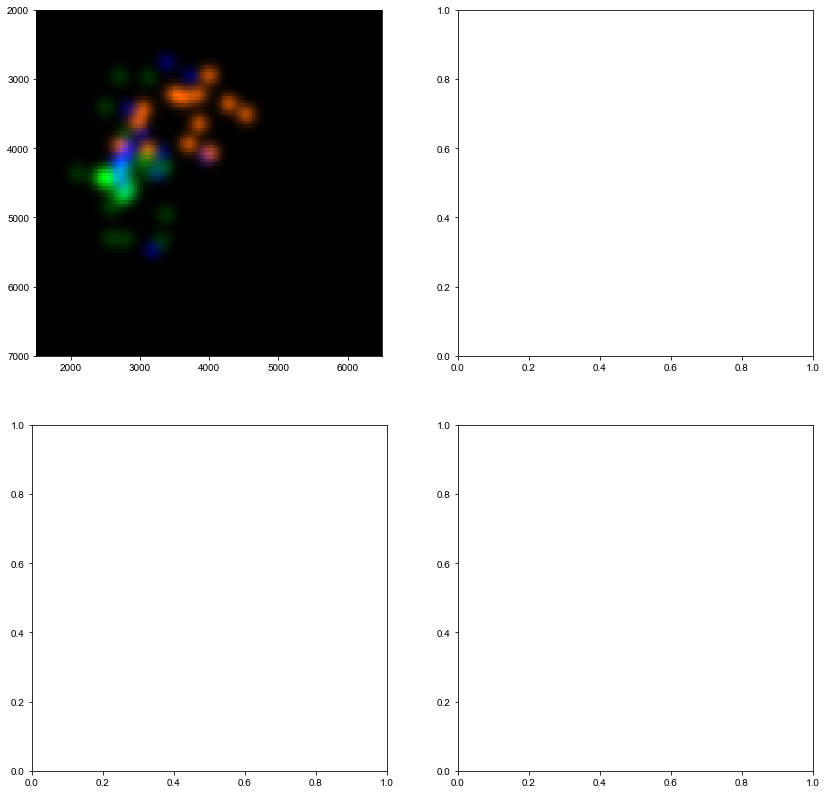

In [48]:
# # Show density plot

# def density_estimation_cluster(cluster, group="soma", col_steps=100, row_steps=120, plot=True, bandwidth=50):

#     # 1. Get data matrix
#     if group == "soma":
#         collim = (2000, 7000)
#         rowlim = (1500, 6500)
#         df = soma_df[soma_df.clusters==cluster]
#     elif group == "axon":
#         collim = (4000, 6000)
#         rowlim = (3000, 6000)
#         df = axon_df[axon_df.clusters==cluster]
#     else:
#         return
    
#     # 2. Get density matrix
#     kde = sklearn.neighbors.KernelDensity(bandwidth=bandwidth)
#     kde.fit(df[['y', 'z']])

#     p = np.zeros((row_steps, col_steps))
#     xs = np.linspace(collim[0], collim[1], num=col_steps)
#     ys = np.linspace(rowlim[0], rowlim[1], num=row_steps)
#     for i in range(col_steps):
#         for j in range(row_steps):
# #             p[i,j] = kde.score(np.array([xs[i], ys[j]]).reshape(1,2))
#             p[j,i] = np.exp(kde.score(np.array([xs[i], ys[j]]).reshape(1,2)))
#     p = p / np.sum(p)
    
#     # Plot
#     if plot:
#         fig, ax = plt.subplots(1,1, figsize=(7,7))
#         ax.imshow(p)
#     return p

# def as_plot_data(p, color):
#     scale = color / np.max(color)
#     res = np.zeros((p.shape[0], p.shape[1], 3))
#     p = p / np.max(p)
#     res[:,:,0] = p * scale[0]
#     res[:,:,1] = p * scale[1]
#     res[:,:,2] = p * scale[2]
#     return res


# def merge_plot_data(p_list, color_list):
#     res = None
#     for i, p in enumerate(p_list):
#         plt_data = as_plot_data(p, color_list[i])
#         if res is None:
#             res = plt_data
#         else:
#             res = res + plt_data
# #     for i in range(3):
# #         print(i, res.shape)
# #         if np.max(res[:,:,i])>1:
# #             res[:,:,i] = res[:,:,i] / np.max(res[:,:,i])
#     res = res / np.max(res)
#     return res


# bw = 100
# fig, ax = plt.subplots(2,2, figsize=(14,14))

# p_list = []
# color_list = []
# p0 = density_estimation_cluster("c0", plot=False, bandwidth=bw); p_list.append(p0); color_list.append(blue)
# p1 = density_estimation_cluster("c1", plot=False, bandwidth=bw); p_list.append(p1); color_list.append(orange)
# p2 = density_estimation_cluster("c2", plot=False, bandwidth=bw); p_list.append(p2); color_list.append(green)
# # p3 = density_estimation_cluster("c3", plot=False, bandwidth=300); p_list.append(p3); color_list.append(red)

# plt_data = merge_plot_data(p_list, color_list)
# ax[0,0].imshow(np.swapaxes(plt_data, 0,1), extent=(1500, 6500, 7000, 2000), alpha=1)
# # ax[0,0].imshow(np.max(cp_map, axis=0), extent=(0, z_max, y_max, 0), cmap="Greys", alpha=0.05)
# ax[0,0].set_ylim((2000, 7000))
# ax[0,0].set_xlim((1500, 6500))
# # sns.scatterplot('z', 'y', 
# #                 data=soma_df, 
# #                 hue='clusters', hue_order=sorted(list(set(soma_df.clusters.tolist()))),
# #                 style='CreLine',
# #                 ax=ax[0])

# ax[0,0].invert_yaxis()

# ax[1,0].imshow(np.max(cp_map, axis=0), extent=(0, z_max, y_max, 0), cmap="Greys", alpha=0.25)
# ax[1,0].set_ylim((2000, 7000))
# ax[1,0].set_xlim((1500, 6500))
# ax[1,0].invert_yaxis()

# p_list = []
# color_list = []
# p0 = density_estimation_cluster("c0", "axon", plot=False, bandwidth=bw); p_list.append(p0); color_list.append(blue)
# p1 = density_estimation_cluster("c1", "axon", plot=False, bandwidth=bw); p_list.append(p1); color_list.append(orange)
# p2 = density_estimation_cluster("c2", "axon", plot=False, bandwidth=bw); p_list.append(p2); color_list.append(green)
# # p3 = density_estimation_cluster("c3", "axon", plot=False, bandwidth=300); p_list.append(p3); color_list.append(red)

# plt_data = merge_plot_data(p_list, color_list)
# ax[0,1].imshow(np.swapaxes(plt_data, 0,1), extent=(3000, 6000, 6000, 4000), alpha=1)
# # ax[0,1].imshow(np.max(snr_map, axis=0), extent=(0, z_max, y_max, 0), cmap="Greys", alpha=0.05)
# ax[0,1].set_ylim((4000, 6000))
# ax[0,1].set_xlim((3000, 6000))
# ax[0,1].invert_yaxis()
# # cell_list = axon_df[axon_df.clusters==cluster].index.tolist()
# # df_list = [my_get_segments(axon_dict[i]).loc[:,['rho'] for i in cell_list]
# # df = pd.concat(df_list, axis=1)

# ax[1,1].imshow(np.max(snr_map, axis=0), extent=(0, z_max, y_max, 0), cmap="Greys", alpha=0.25)
# ax[1,1].set_ylim((4000, 6000))
# ax[1,1].set_xlim((3000, 6000))
# ax[1,1].invert_yaxis()

# fig.savefig("topography_snr.pdf")

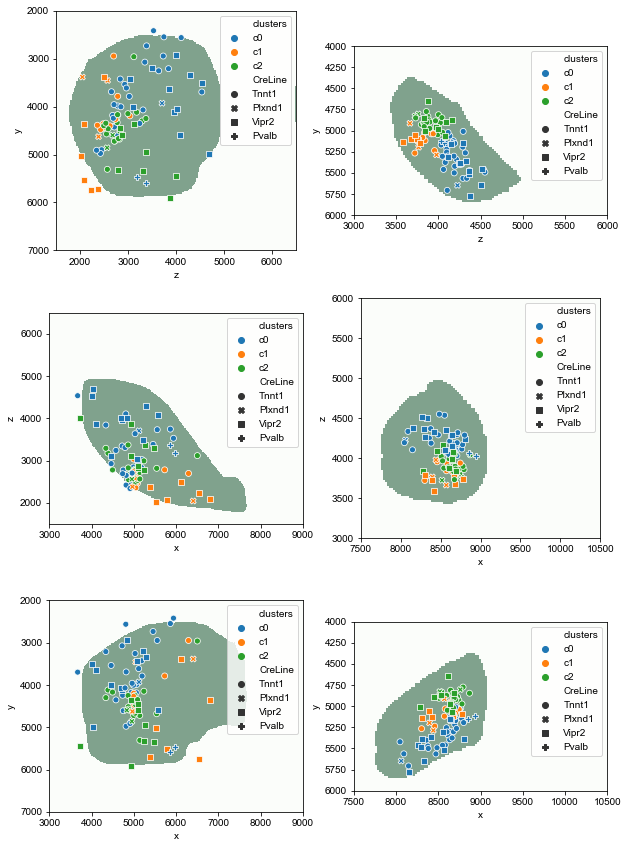

In [177]:
cp_map = (nmt.annotation.array == nmt.bs.name_to_id('CP'))
snr_map = (nmt.annotation.array == nmt.bs.name_to_id('SNr'))
axes_dict = {'x':['z', 'y'], 'y':['x', 'z'], 'z':['x', 'y']}
axis_list = ['x', 'y', 'z']
transpose_dict = {'x':0, 'y':1, 'z':1}
def sub_plot(cur_map, cur_axis, ax, df):
    xax, yax = axes_dict[cur_axis]
    sns.scatterplot(xax, yax, 
                data=df, 
                hue='clusters', hue_order=sorted(list(set(df.clusters.tolist()))),
                style='CreLine',
                ax=ax)

    ax.set_xlim(lim_dict[xax])
    ax.set_ylim(lim_dict[yax])
    tp = np.max(cur_map, axis=axis_list.index(cur_axis))
    if transpose_dict[cur_axis]:
        tp = np.transpose(tp)
    ax.imshow(tp, 
                  extent=(0, nmt.annotation.micron_size[xax], 
                          0, nmt.annotation.micron_size[yax]), 
                  cmap='Greens', alpha=0.5, origin='lower')
    if yax=="y":
        ax.invert_yaxis()
    return 

fig, ax = plt.subplots(3,2, figsize=(10,15))
# 1.Soma
lim_dict = {'x':(3000, 9000), 'y':(2000, 7000), 'z':(1500, 6500)}
for i, cur_axis in enumerate(axis_list):
    cur_ax = ax[i,0]
    sub_plot(cp_map, cur_axis, cur_ax, soma_df)

# 2.Axon
lim_dict = {'x':(7500, 10500), 'y':(4000, 6000), 'z':(3000, 6000)}
for i, cur_axis in enumerate(axis_list):
    cur_ax = ax[i,1]
    sub_plot(snr_map, cur_axis, cur_ax, axon_df)

fig.savefig("SNr_subgroup.pdf")